#### Background
As smart phone penetration reaches the hundreds of millions mark, O2O (Online to Offline) requires businesses to have a strong presence both offline and online. APPs with O2O capabilities accumulate daily consumer behaviour and location data that require big data and commercial operations management. The competition at hand focuses on coupon redemption rates. Sending coupons is a general O2O marketing tool used to activate existing customers and attract new ones. While customers are happy to receive coupons that they want, they are frustrated when receiving coupons that they do not need. For merchants, sending unwanted coupons may erode brand equity and hinder marketing expense forecasting. Targeted marketing is an important technology to increase the coupon redemption rate, providing relevant discounts to customers and effective marketing tools to businesses. The competition provides participants with abundant O2O data in this field and expects contestants to predict whether the customer will use the coupon within a specified time frame.
### Data
This competition provides real online and offline user consumption data from January 1, 2016 to June 30, 2016. The contestants are expected to predict the probability of customers redeeming a coupon within 15 days of receiving it.
Note: To protect the privacy of users and merchants, data is desensitized and under biased sampling.
### Evaluation
The results are evaluated based on the average AUC value. That is, the AUC value is calculated for every coupon_id. The average of each AUC value is the evaluation score. More information on AUC value calculation method on wikipedia.


In [56]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_test=  pd.read_csv('ccf_offline_stage1_test_revised.csv')
print(df_test.shape)
df_test.head(20)

(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708
5,4005121,450,9983,30:5,0.0,20160706
6,4347394,450,9983,30:5,0.0,20160716
7,3094273,760,13602,30:5,1.0,20160727
8,5139970,450,9983,30:5,10.0,20160729
9,3237121,760,13602,30:5,1.0,20160703


In [140]:
df_test.isna().sum()

User_id              0
Merchant_id          0
Coupon_id            0
Discount_rate        0
Distance         12064
Date_received        0
dtype: int64

In [157]:
coupon_ids_test = df_test[(df_test["Coupon_id"].isna()==False)]

coupons_test = np.array(coupon_ids_test["Coupon_id"].astype(int))
coupons_test

array([ 9983,  3429,  6928, ...,  7590, 13602,   613])

### Training Offline Data

In [5]:
df_of = pd.read_csv('ccf_offline_stage1_train.csv')
print(df_of.shape)
df_of.head(10)

(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN
5,1439408,2632,NaN,NaN,0.0,NaN,20160516.0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0
7,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
8,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
9,2029232,450,1532.0,30:5,0.0,20160530.0,NaN


In [6]:
df_of.isna().sum()

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

In [7]:
df_of['User_id'].value_counts().describe()

count    539438.000000
mean          3.253171
std           4.767551
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         264.000000
Name: User_id, dtype: float64

In [8]:
df_of[df_of["Date"].isna()].shape

(977900, 7)

In [9]:
df_of[(df_of["Date"].isna()) & (df_of["Coupon_id"].isna())].shape

(0, 7)

In [10]:
df_of.Coupon_id.describe()

count    1.053282e+06
mean     6.815398e+03
std      4.174276e+03
min      1.000000e+00
25%      2.840000e+03
50%      7.430000e+03
75%      1.032300e+04
max      1.404500e+04
Name: Coupon_id, dtype: float64

In [11]:
df_of.Coupon_id.nunique()

9738

In [12]:
df_of[df_of["Date"].isna()==False].shape

(776984, 7)

In [13]:
df_of[(df_of["Date"].isna()==False) & (df_of["Coupon_id"].isna())].shape

(701602, 7)

In [14]:
df_of[(df_of["Date"].isna()==False) & (df_of["Coupon_id"].isna()==False)].shape

(75382, 7)

In [158]:
coupon_ids_of = df_of[(df_of["Coupon_id"].isna()==False)]
coupons_of = coupon_ids_of["Coupon_id"].astype(int).unique()
min(coupons_of)

1

In [161]:
len(set(coupons_of).intersection(set(coupons_test)))

1118

In [162]:
df_of.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date'],
      dtype='object')

In [305]:
x = 'g8h.|$hTdo+jC9^@'    
df_of_unique = (df_of.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_of_unique

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
0,4,1433,8735.0,30:5,10.0,20160214.0,NaN,1
1,4,1469,2902.0,0.95,10.0,20160607.0,NaN,1
2,35,3381,1807.0,300:30,0.0,20160130.0,NaN,1
3,35,3381,9776.0,10:5,0.0,20160129.0,NaN,1
4,35,3381,11951.0,200:20,0.0,20160129.0,NaN,1
...,...,...,...,...,...,...,...,...
1716986,7360967,3103,NaN,NaN,2.0,NaN,20160120.0,1
1716987,7360967,6485,10323.0,20:5,1.0,20160322.0,NaN,2
1716988,7361024,1433,8735.0,30:5,10.0,20160211.0,NaN,1
1716989,7361032,2146,11173.0,100:10,2.0,20160129.0,NaN,1


### Training Online Data

In [260]:
df_on = pd.read_csv('ccf_online_stage1_train.csv')
print(df_on.shape)
df_on_total = df_on.shape[0]
df_on.head()

(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [261]:
df_on.isna().sum()

User_id                 0
Merchant_id             0
Action                  0
Coupon_id        10557469
Discount_rate    10557469
Date_received    10557469
Date               655898
dtype: int64

In [262]:
df_on[df_on["Date"].isna()].shape

(655898, 7)

In [263]:
#Date==Null and Coupon_id==Null: no such cases
df_on[(df_on["Date"].isna()) & (df_on["Coupon_id"].isna())].shape

(0, 7)

In [264]:
#Date==Null and Coupon_id!=Null: Coupon not redeemed(5.73%) and customer only 'gets Coupon'
df_not_redeemed = df_on[(df_on["Date"].isna()) & (df_on["Coupon_id"].isna()==False)]
df_not_redeemed.shape

(655898, 7)

In [265]:
df_not_redeemed["Action"].describe()

count    655898.0
mean          2.0
std           0.0
min           2.0
25%           2.0
50%           2.0
75%           2.0
max           2.0
Name: Action, dtype: float64

In [266]:
df_on[df_on["Date"].isna()==False].shape


(10773928, 7)

In [267]:
#Date!=Null and Coupon_id==Null: No coupon(92.36%) and the customer only 'clicks' and 'buys'
df_no_coupon = df_on[(df_on["Date"].isna()==False) & (df_on["Coupon_id"].isna())]
df_no_coupon.shape

(10557469, 7)

In [268]:
df_no_coupon["Action"].unique()

array([1, 0])

In [269]:
#82.23% times customer only clicks
df_no_coupon[df_no_coupon["Action"]==0].shape

(9401780, 7)

In [270]:
#10.11% times customer buys with no coupon
df_no_coupon[df_no_coupon["Action"]==0]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0
5,14336199,18907,0,NaN,NaN,NaN,20160618.0
6,14336199,18907,0,NaN,NaN,NaN,20160618.0
...,...,...,...,...,...,...,...
11429819,12985299,10813,0,NaN,NaN,NaN,20160414.0
11429820,13087731,52509,0,NaN,NaN,NaN,20160609.0
11429821,13087731,27715,0,NaN,NaN,NaN,20160629.0
11429822,13087731,52005,0,NaN,NaN,NaN,20160324.0


In [271]:
df_on[(df_on["Date"].isna()==False) & (df_on["Coupon_id"].isna()==False)].shape

(216459, 7)

In [272]:
#coupon redeemed 1.89% times ('buys')
df_redeemed = df_on[(df_on["Date"].isna()==False) & (df_on["Coupon_id"].isna()==False)]
df_redeemed.shape

(216459, 7)

In [273]:
df_redeemed["Action"].unique()

array([1])

In [274]:
df_on.nunique(axis = 0) 

User_id          762858
Merchant_id        7999
Action                3
Coupon_id         27747
Discount_rate        64
Date_received       167
Date                182
dtype: int64

In [275]:
df_on.groupby(['User_id','Merchant_id']).head()


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0
...,...,...,...,...,...,...,...
11429821,13087731,27715,0,NaN,NaN,NaN,20160629.0
11429822,13087731,52005,0,NaN,NaN,NaN,20160324.0
11429823,13087731,45611,0,NaN,NaN,NaN,20160422.0
11429824,13683699,18009,1,NaN,NaN,NaN,20160323.0


In [276]:
#When coupon==fixed, coupon redeemed the same day
df_fix = df_on[df_on["Coupon_id"]=="fixed"]
df_fix.shape, df_fix[df_fix["Date_received"]==df_fix["Date"]].shape

((131546, 7), (131546, 7))

In [277]:
df_on.index.name="Index"

In [278]:
df_on[(df_on["User_id"]==14336199)]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
Index,,,,,,,
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0
5,14336199,18907,0,NaN,NaN,NaN,20160618.0
6,14336199,18907,0,NaN,NaN,NaN,20160618.0
7,14336199,18907,0,NaN,NaN,NaN,20160618.0
8,14336199,18907,0,NaN,NaN,NaN,20160618.0
9,14336199,18907,0,NaN,NaN,NaN,20160618.0
10,14336199,38810,0,NaN,NaN,NaN,20160126.0


In [279]:
df_on[(df_on["User_id"]==10998966) & (df_on["Merchant_id"]==14305)]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
Index,,,,,,,
8451625,10998966,14305,2,100020104,500:50,20160218.0,NaN
8451626,10998966,14305,2,100020104,500:50,20160218.0,NaN
8451627,10998966,14305,0,NaN,NaN,NaN,20160218.0
8451628,10998966,14305,0,NaN,NaN,NaN,20160218.0
8451629,10998966,14305,0,NaN,NaN,NaN,20160218.0
...,...,...,...,...,...,...,...
8453528,10998966,14305,2,100043310,300:100,20160505.0,NaN
8453529,10998966,14305,1,NaN,NaN,NaN,20160104.0
8453530,10998966,14305,1,NaN,NaN,NaN,20160104.0


In [280]:
df_on.columns

Index(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date'],
      dtype='object')

In [281]:
df_on.drop_duplicates().shape

(5822543, 7)

In [282]:
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count
0,4,25104,2,100145044,100:10,20160331.0,NaN,1
1,4,45612,1,NaN,NaN,NaN,20160308.0,1
2,36,46701,0,NaN,NaN,NaN,20160120.0,1
3,64,11200,0,NaN,NaN,NaN,20160526.0,1
4,64,29214,0,NaN,NaN,NaN,20160606.0,1
...,...,...,...,...,...,...,...,...
5822538,15499999,55202,0,NaN,NaN,NaN,20160317.0,8
5822539,15499999,56502,0,NaN,NaN,NaN,20160227.0,1
5822540,15499999,59011,0,NaN,NaN,NaN,20160321.0,1
5822541,15499999,59512,0,NaN,NaN,NaN,20160116.0,1


In [283]:
df_on_unique.Count.describe()

count    5.822543e+06
mean     1.963030e+00
std      3.430659e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.300000e+02
Name: Count, dtype: float64

In [284]:
arr = list(df_on_unique["Count"])
arr.sort(reverse=True)
arr[:10]

[630, 504, 444, 432, 378, 367, 336, 336, 333, 322]

In [285]:
df_on_unique.nunique()

User_id          762858
Merchant_id        7999
Action                3
Coupon_id         27747
Discount_rate        64
Date_received       167
Date                182
Count               233
dtype: int64

In [286]:
coupon_ids = df_on_unique[(df_on_unique["Coupon_id"].isna()==False) & (df_on_unique["Coupon_id"]!='fixed')]
coupons = coupon_ids["Coupon_id"].astype(int).unique()
max(coupons)

100233610

In [287]:
df_on_unique[df_on_unique["User_id"]==10998966]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count
2182122,10998966,11105,0,NaN,NaN,NaN,20160509.0,3
2182123,10998966,11500,0,NaN,NaN,NaN,20160122.0,3
2182124,10998966,14000,0,NaN,NaN,NaN,20160405.0,3
2182125,10998966,14305,0,NaN,NaN,NaN,20160102.0,3
2182126,10998966,14305,0,NaN,NaN,NaN,20160104.0,210
2182127,10998966,14305,0,NaN,NaN,NaN,20160105.0,3
2182128,10998966,14305,0,NaN,NaN,NaN,20160106.0,81
2182129,10998966,14305,0,NaN,NaN,NaN,20160107.0,33
2182130,10998966,14305,0,NaN,NaN,NaN,20160108.0,6
2182131,10998966,14305,0,NaN,NaN,NaN,20160109.0,6


### Users involved in both online and offline transactions

In [288]:
on_off = df_on_unique.append(df_of_unique, sort=False)

In [289]:
on_off

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,20160331.0,NaN,1,NaN
1,4,45612,1.0,NaN,NaN,NaN,20160308.0,1,NaN
2,36,46701,0.0,NaN,NaN,NaN,20160120.0,1,NaN
3,64,11200,0.0,NaN,NaN,NaN,20160526.0,1,NaN
4,64,29214,0.0,NaN,NaN,NaN,20160606.0,1,NaN
...,...,...,...,...,...,...,...,...,...
1716986,7360967,3103,NaN,NaN,NaN,NaN,20160120.0,1,2.0
1716987,7360967,6485,NaN,10323,20:5,20160322.0,NaN,2,1.0
1716988,7361024,1433,NaN,8735,30:5,20160211.0,NaN,1,10.0
1716989,7361032,2146,NaN,11173,100:10,20160129.0,NaN,1,2.0


In [290]:
#number of users having both online and offline presence
users_on_off = set(df_on_unique["User_id"].unique()).intersection(set(df_of_unique["User_id"]))
len(users_on_off)

267448

In [291]:
users_on = set(df_on_unique["User_id"].unique())  #number of users in online data
users_of = set(df_of_unique["User_id"].unique())  #number of users in offline data
len(users_on), len(users_of)

(762858, 539438)

In [292]:
#number of users using only online and only offline services
len(users_on - users_on_off), len(users_of - users_on_off)

(495410, 271990)

In [293]:
on_off = on_off[on_off['User_id'].isin(list(users_on_off))]
on_off.shape

(2168771, 9)

In [294]:
on_off[on_off["User_id"]==36]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
2,36,46701,0.0,NaN,NaN,NaN,20160120.0,1,NaN
6,36,1041,NaN,13490,30:5,20160125.0,NaN,1,4.0
7,36,5717,NaN,12349,20:5,20160125.0,NaN,1,8.0


In [295]:
on_off = on_off.sort_values(by=['User_id'])

In [296]:
on_off.reset_index(drop=True, inplace=True)
on_off

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,20160331.0,NaN,1,NaN
1,4,1469,NaN,2902,0.95,20160607.0,NaN,1,10.0
2,4,1433,NaN,8735,30:5,20160214.0,NaN,1,10.0
3,4,45612,1.0,NaN,NaN,NaN,20160308.0,1,NaN
4,36,5717,NaN,12349,20:5,20160125.0,NaN,1,8.0
...,...,...,...,...,...,...,...,...,...
2168766,7360967,52910,1.0,NaN,NaN,NaN,20160407.0,32,NaN
2168767,7360967,760,NaN,NaN,NaN,NaN,20160625.0,1,1.0
2168768,7361032,2146,NaN,11173,100:10,20160129.0,NaN,1,2.0
2168769,7361032,59701,1.0,NaN,NaN,NaN,20160506.0,1,NaN


In [297]:
on_off[(on_off["Action"].isna()==True)]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
1,4,1469,NaN,2902,0.95,20160607.0,NaN,1,10.0
2,4,1433,NaN,8735,30:5,20160214.0,NaN,1,10.0
4,36,5717,NaN,12349,20:5,20160125.0,NaN,1,8.0
6,36,1041,NaN,13490,30:5,20160125.0,NaN,1,4.0
8,64,2146,NaN,11173,100:10,20160129.0,NaN,1,2.0
...,...,...,...,...,...,...,...,...,...
2168761,7360967,3103,NaN,2375,30:1,20160120.0,NaN,1,2.0
2168762,7360967,760,NaN,NaN,NaN,NaN,20160626.0,1,1.0
2168767,7360967,760,NaN,NaN,NaN,NaN,20160625.0,1,1.0
2168768,7361032,2146,NaN,11173,100:10,20160129.0,NaN,1,2.0


In [298]:
#on_off_redeemed = on_off[(on_off["Date"].isna()==False) & (on_off["Coupon_id"].isna()==False)]
on_off["Date"] = pd.to_datetime(on_off["Date"],format='%Y%m%d')
on_off["Date_received"] = pd.to_datetime(on_off["Date_received"],format='%Y%m%d')
on_off

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
2,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,36,5717,NaN,12349,20:5,2016-01-25,NaT,1,8.0
...,...,...,...,...,...,...,...,...,...
2168766,7360967,52910,1.0,NaN,NaN,NaT,2016-04-07,32,NaN
2168767,7360967,760,NaN,NaN,NaN,NaT,2016-06-25,1,1.0
2168768,7361032,2146,NaN,11173,100:10,2016-01-29,NaT,1,2.0
2168769,7361032,59701,1.0,NaN,NaN,NaT,2016-05-06,1,NaN


In [299]:
date_redeemed = on_off[(on_off["Date"].isna()==False) & (on_off["Coupon_id"].isna()==False)].Date



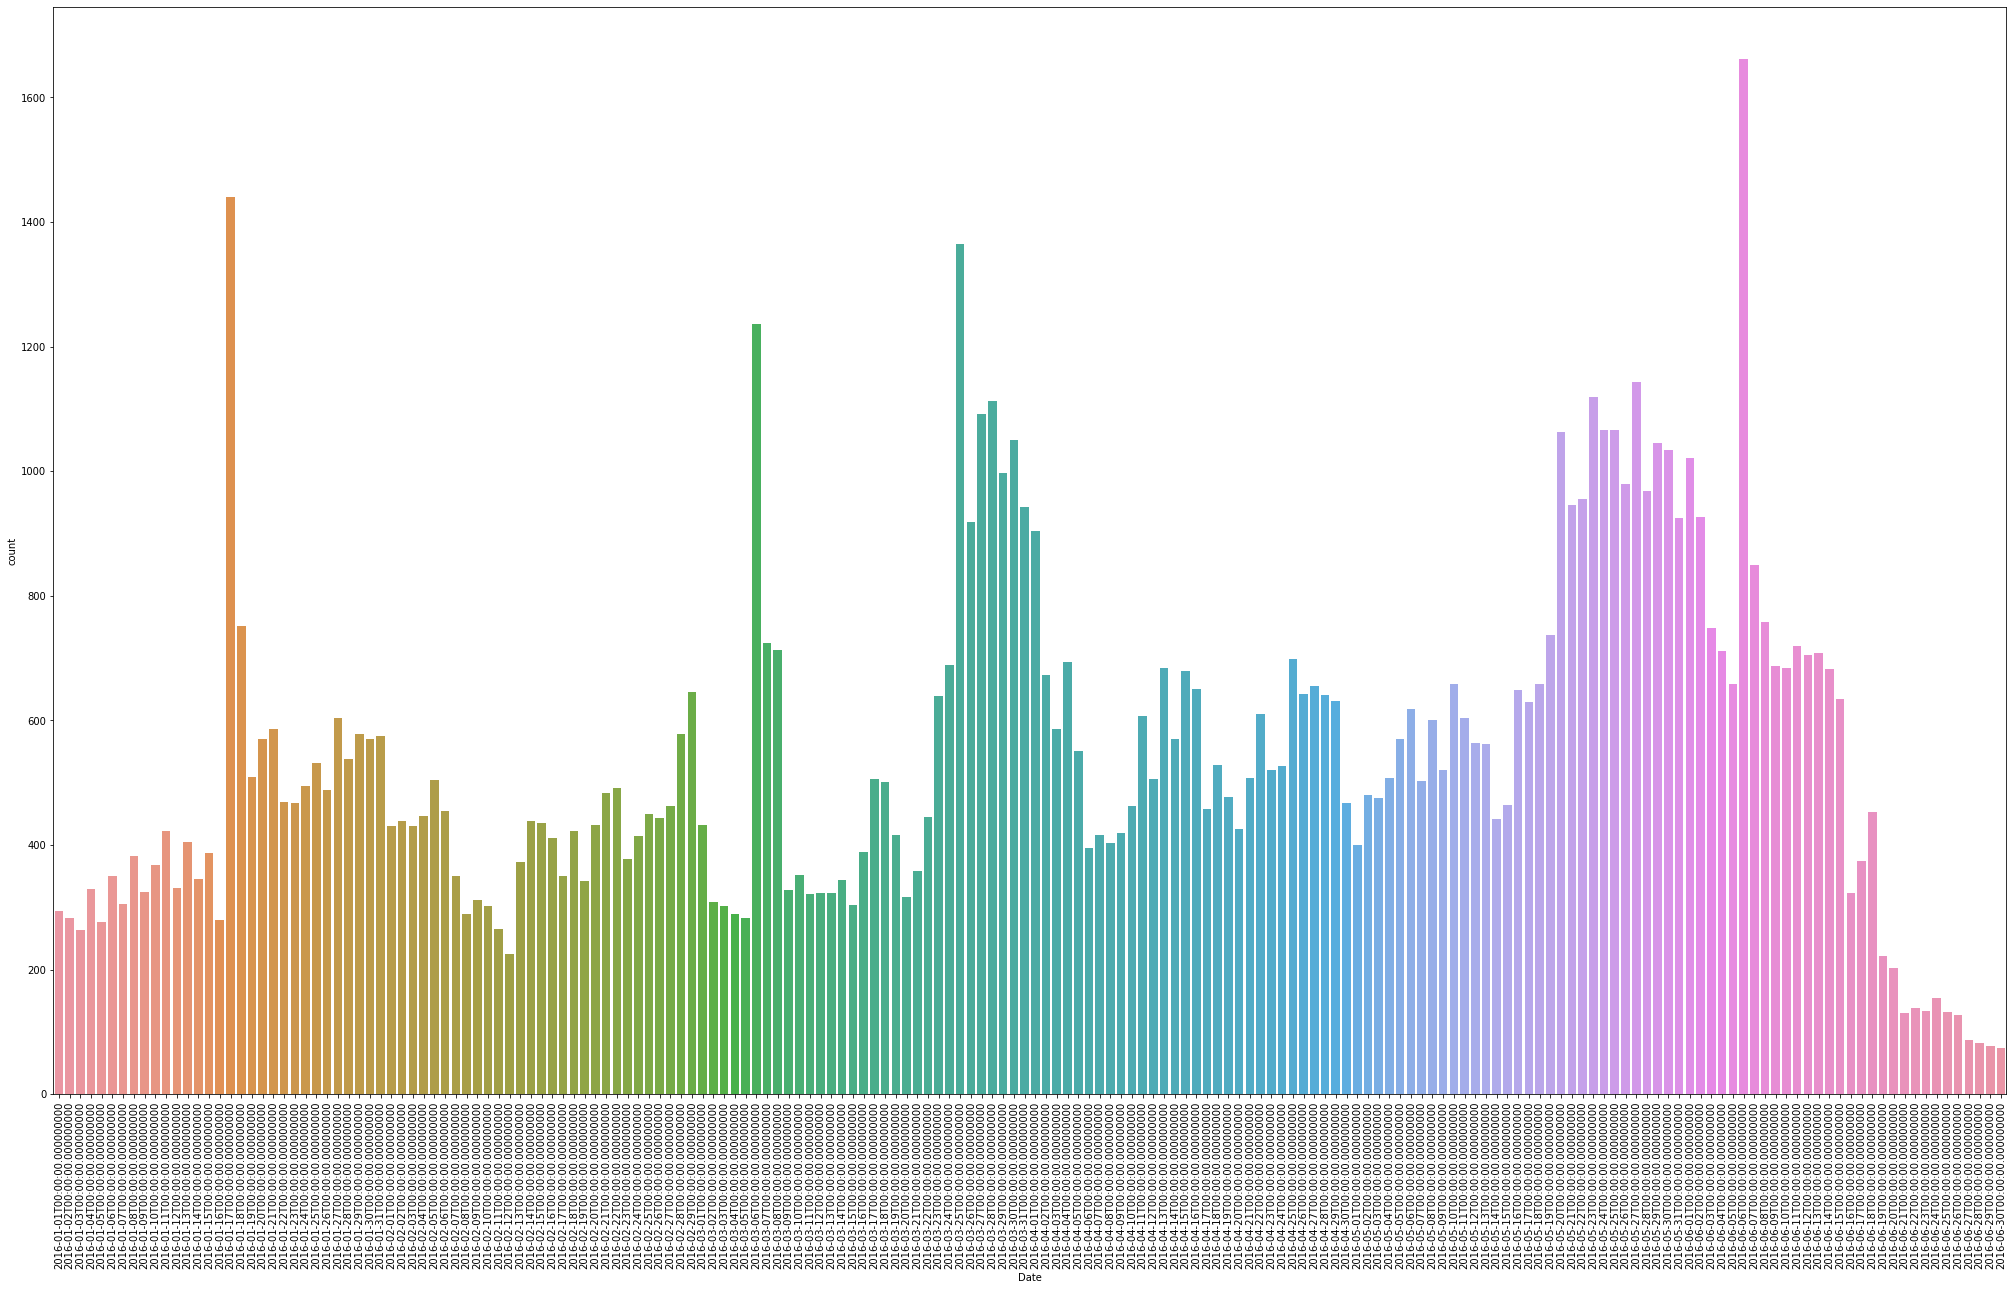

In [300]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_redeemed)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

### Only Offline Users

In [307]:
df_offline = df_of_unique[df_of_unique['User_id'].isin(list(users_of - users_on_off))]
date_redeemed_of = df_offline[(df_offline["Date"].isna()==False) & (df_offline["Coupon_id"].isna()==False)].Date

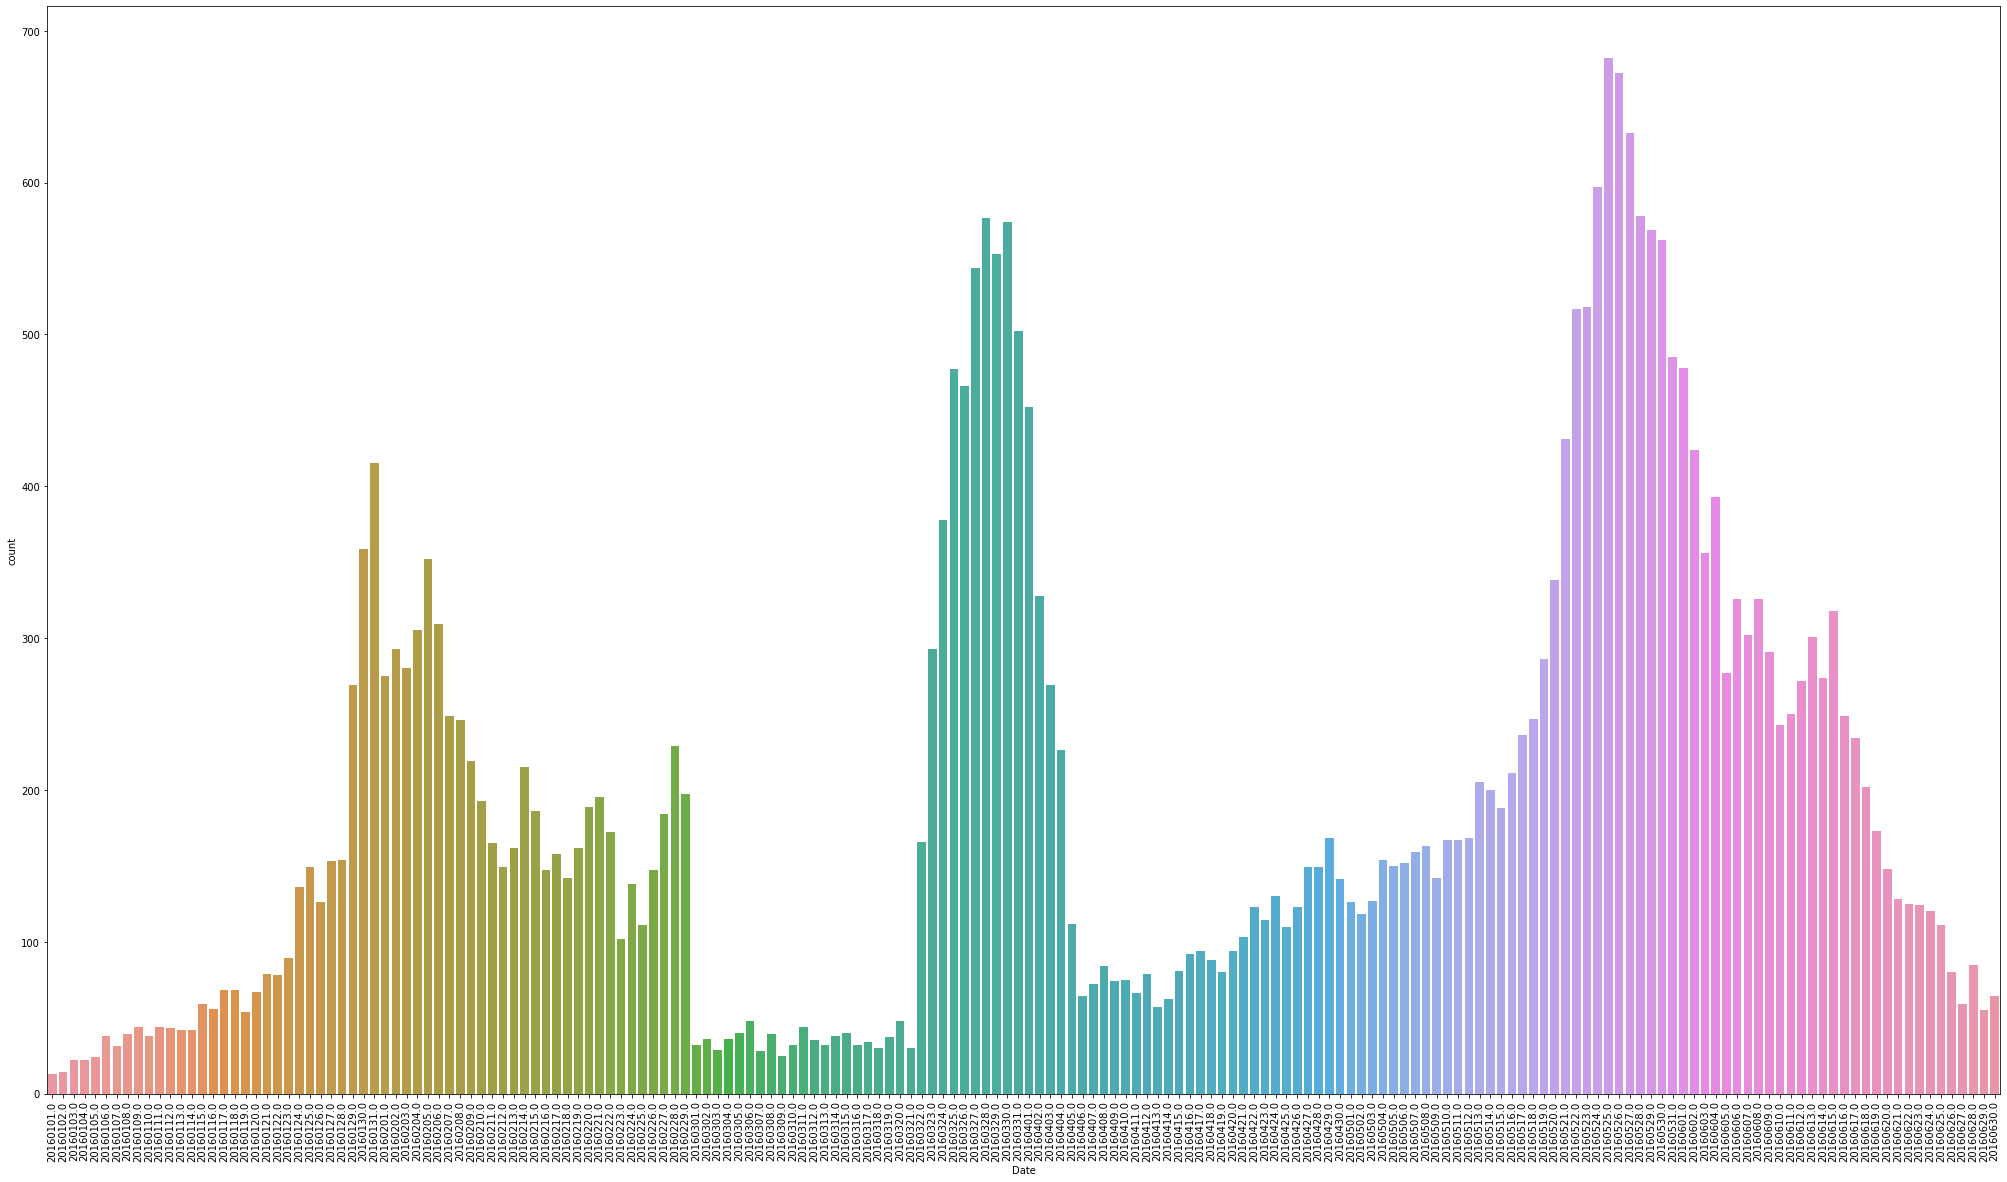

In [308]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_redeemed_of)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

### Only Online Users


In [310]:
df_online = df_on_unique[df_on_unique['User_id'].isin(list(users_on - users_on_off))]
date_redeemed_on = df_online[(df_online["Date"].isna()==False) & (df_online["Coupon_id"].isna()==False)].Date

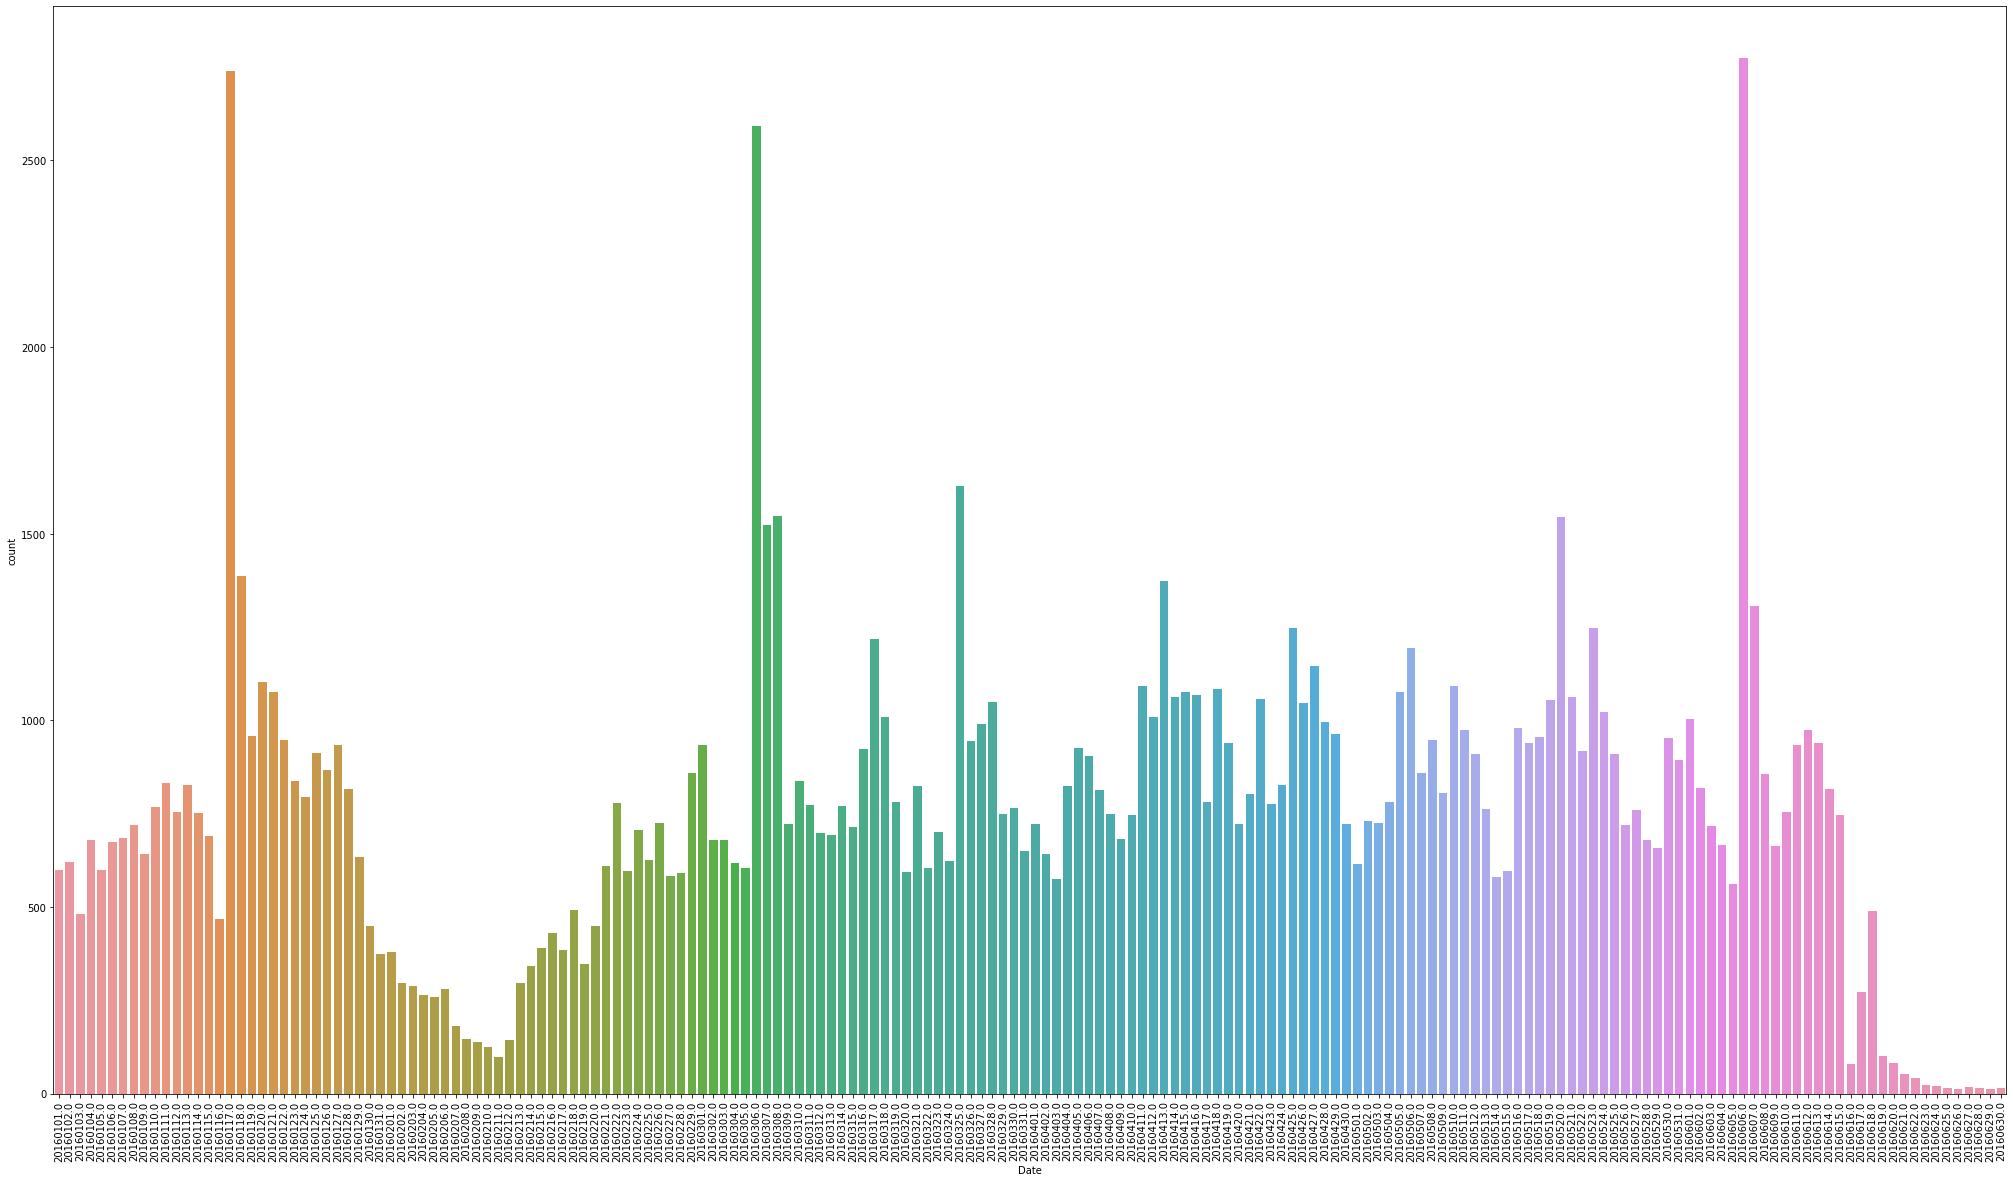

In [311]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_redeemed_on)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()